# Setup

In [1]:
%cd ..

C:\Users\pooya\Codes\BubbleTracking


In [2]:
%load_ext autoreload
%autoreload 2

In [31]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
import os
import numpy as np
import PIL
from PIL import Image, ImageDraw
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from utils import collate_fn

# Create Datasets

In [4]:
imgs_path = Path('./data/images/Source/')
mask_path_train = Path('./data/joined_masks/train/')
mask_path_test = Path('./data/joined_masks/test/')

In [40]:
class BubbleDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, mask_path,scale = 1):
        super(BubbleDataset, self).__init__()
        image_id = os.listdir(mask_path)
        ids = []
        for iid in image_id:
            path = os.path.join(mask_path, iid)
            mask = Image.open(path) 
            if np.max(mask)>0:
                ids.append(iid)
        self.image_id = ids
        self.scale = scale
        self.image_path = img_path
        self.mask_path = mask_path

    def get_boxes(self, idx):
        mask, _ = self.get_mask(idx)
        array = np.array(mask)
        if array.max() == 0:
            return []

        obj_ids = np.unique(array)[1:]

        boxes = []
        scale = self.scale
        for i in obj_ids:
            pos = np.where(array == i)
            xmin = np.min(pos[1])*scale
            xmax = np.max(pos[1])*scale
            ymin = np.min(pos[0])*scale
            ymax = np.max(pos[0])*scale
            boxes.append([xmin, ymin, xmax, ymax])
        return np.array(boxes)

    def get_image(self, idx):
        path = os.path.join(self.image_path, self.image_id[idx])
        image = Image.open(path)
        if self.scale !=1:
            scale = self.scale
            size = (int(d*scale) for d in image.size)
            image = image.resize(size,Image.BICUBIC)
        return image

    def get_mask(self, idx):
        path = os.path.join(self.mask_path, self.image_id[idx])
        mask = Image.open(path)
        if self.scale!=1:
            scale = self.scale
            size = (int(d*scale) for d in mask.size)
            mask = mask.resize(size,Image.BICUBIC)
        if np.max(mask) == 0:
            return mask, np.array(mask)
        nmax = int(np.max(mask))
        
        layered = np.zeros((nmax, np.shape(mask)[0], np.shape(mask)[1]))
        for i in range(nmax):
            layered[i, :, :] = mask == (i + 1)
        return mask, layered

    def visualise(self, idx):
        img = self.get_image(idx)
        boxes = self.get_boxes(idx)
        draw = ImageDraw.Draw(img)
        for i in range(boxes.shape[0]):
            draw.rectangle(list(boxes[i, :]), outline='red', width=3)
        return img

    def __getitem__(self, idx):
        target = {}
        boxes = self.get_boxes(idx)
        _, masks = self.get_mask(idx)
        if len(boxes) == 0:
            area = torch.tensor([],dtype=torch.float)
            img = self.get_image(idx)
            img = np.array(img)
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float)
            target['labels'] = torch.ones((0, ), dtype=torch.int64)
            target['masks'] = torch.as_tensor(masks,dtype = torch.uint8)
            target['image_id'] = torch.tensor([idx])
            target['area'] = area
            target['iscrowd'] = torch.zeros((0, ), dtype=torch.int64)
        else:
            area = torch.as_tensor(
                (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                dtype=torch.float)
            usable = area>0
            _, masks = self.get_mask(idx)
            img = self.get_image(idx)
            img = np.array(img)
            target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)[usable]
            target['labels'] = torch.ones((len(usable), ), dtype=torch.int64)
            target['masks'] = torch.as_tensor(masks[:len(usable)],dtype = torch.uint8)[usable]
            target['image_id'] = torch.tensor([idx])
            target['area'] = area[usable]
            target['iscrowd'] = torch.zeros((len(usable), ), dtype=torch.int64)

        return torch.tensor(img).permute(2, 0, 1).float(), target

    def __len__(self):
        return len(self.image_id)

    @property
    def length(self):
        return len(self)

In [41]:
dstr = BubbleDataset(imgs_path,mask_path_train,scale=.5)
dsval =BubbleDataset(imgs_path,mask_path_test,scale=.5)

In [43]:
loader = DataLoader(dstr,
                    batch_size=2,
                    shuffle=True,
                    collate_fn=collate_fn
                   )
test_loader = DataLoader(
    dsval,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

# Create Model

In [44]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import utils
from engine import train_one_epoch, evaluate

In [45]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [46]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [47]:
num_classes = 2
model = get_model_instance_segmentation(num_classes)

# Train Model

In [48]:
device =torch.device('cuda')
model = model.to(device)

In [49]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr = 0.001, weight_decay=1e-3)
lr_sch = optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=.1)

In [50]:
epochs = 10
for epoch in range(epochs):
    train_one_epoch(model,optimizer,loader,device,epoch,12)
    lr_sch.step()
    evaluate(model,test_loader,device=device)

C:\Users\pooya\anaconda3\lib\site-packages\torch\nn\functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
C:\Users\pooya\anaconda3\lib\site-packages\torchvision\ops\boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/84]  eta: 0:05:47  lr: 0.000013  loss: 578.3942 (578.3942)  loss_classifier: 6.1463 (6.1463)  loss_box_reg: 5.0651 (5.0651)  loss_mask: 393.6643 (393.6643)  loss_objectness: 128.0179 (128.0179)  loss_rpn_box_reg: 45.5006 (45.5006)  time: 4.1340  data: 0.3860  max mem: 2680
Epoch: [0]  [12/84]  eta: 0:01:30  lr: 0.000157  loss: 102.1033 (207.7247)  loss_classifier: 1.5635 (2.5812)  loss_box_reg: 2.1835 (2.7786)  loss_mask: 2.6700 (101.8375)  loss_objectness: 69.5737 (82.8609)  loss_rpn_box_reg: 13.0021 (17.6665)  time: 1.2540  data: 0.5198  max mem: 3634
Epoch: [0]  [24/84]  eta: 0:01:09  lr: 0.000302  loss: 16.7896 (112.7158)  loss_classifier: 0.9920 (1.7124)  loss_box_reg: 1.0324 (1.9678)  loss_mask: 0.0000 (52.9555)  loss_objectness: 9.8800 (45.7951)  loss_rpn_box_reg: 2.8432 (10.2850)  time: 1.0685  data: 0.5706  max mem: 3634
Epoch: [0]  [36/84]  eta: 0:00:54  lr: 0.000446  loss: 3.9925 (77.3523)  loss_classifier: 0.4679 (1.3211)  loss_box_reg: 0.8841 (1.6345)  loss

Epoch: [2]  [ 0/84]  eta: 0:02:09  lr: 0.001000  loss: 8.2312 (8.2312)  loss_classifier: 4.8982 (4.8982)  loss_box_reg: 1.4884 (1.4884)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.6946 (0.6946)  loss_rpn_box_reg: 1.1501 (1.1501)  time: 1.5469  data: 0.9913  max mem: 3634
Epoch: [2]  [12/84]  eta: 0:01:18  lr: 0.001000  loss: 3.1765 (3.3122)  loss_classifier: 0.8385 (1.2081)  loss_box_reg: 0.2983 (0.3988)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.7043 (0.7178)  loss_rpn_box_reg: 1.1209 (0.9875)  time: 1.0873  data: 0.5837  max mem: 3634
Epoch: [2]  [24/84]  eta: 0:01:04  lr: 0.001000  loss: 2.6425 (3.4243)  loss_classifier: 0.7300 (1.0006)  loss_box_reg: 0.2338 (0.5600)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.7002 (0.7629)  loss_rpn_box_reg: 1.0209 (1.1009)  time: 1.0775  data: 0.5724  max mem: 3634
Epoch: [2]  [36/84]  eta: 0:00:50  lr: 0.001000  loss: 3.9634 (3.9822)  loss_classifier: 0.8430 (1.4431)  loss_box_reg: 0.3858 (0.5411)  loss_mask: 0.0000 (0.0000)  loss_ob

Epoch: [4]  [ 0/84]  eta: 0:01:19  lr: 0.000100  loss: 2.7984 (2.7984)  loss_classifier: 0.3745 (0.3745)  loss_box_reg: 0.2905 (0.2905)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.6182 (0.6182)  loss_rpn_box_reg: 1.5152 (1.5152)  time: 0.9415  data: 0.4338  max mem: 3634
Epoch: [4]  [12/84]  eta: 0:01:13  lr: 0.000100  loss: 2.5453 (2.6724)  loss_classifier: 0.2901 (0.3026)  loss_box_reg: 0.2923 (0.3040)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.6151 (0.6156)  loss_rpn_box_reg: 1.4185 (1.4502)  time: 1.0243  data: 0.5096  max mem: 3634
Epoch: [4]  [24/84]  eta: 0:01:04  lr: 0.000100  loss: 2.5215 (2.6105)  loss_classifier: 0.3136 (0.3310)  loss_box_reg: 0.3432 (0.3492)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.5991 (0.6074)  loss_rpn_box_reg: 1.2088 (1.3229)  time: 1.0864  data: 0.5616  max mem: 3634
Epoch: [4]  [36/84]  eta: 0:00:51  lr: 0.000100  loss: 2.3765 (2.4911)  loss_classifier: 0.3571 (0.3425)  loss_box_reg: 0.4040 (0.3557)  loss_mask: 0.0000 (0.0000)  loss_ob

Epoch: [6]  [ 0/84]  eta: 0:01:29  lr: 0.000010  loss: 1.9478 (1.9478)  loss_classifier: 0.2325 (0.2325)  loss_box_reg: 0.4440 (0.4440)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.4849 (0.4849)  loss_rpn_box_reg: 0.7864 (0.7864)  time: 1.0681  data: 0.5066  max mem: 3634
Epoch: [6]  [12/84]  eta: 0:01:20  lr: 0.000010  loss: 2.3261 (2.4331)  loss_classifier: 0.2270 (0.2296)  loss_box_reg: 0.4410 (0.4174)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.5093 (0.5025)  loss_rpn_box_reg: 1.1327 (1.2837)  time: 1.1200  data: 0.5702  max mem: 3634
Epoch: [6]  [24/84]  eta: 0:01:06  lr: 0.000010  loss: 2.3022 (2.4355)  loss_classifier: 0.2205 (0.2341)  loss_box_reg: 0.4410 (0.4247)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.5093 (0.5092)  loss_rpn_box_reg: 1.1327 (1.2674)  time: 1.0959  data: 0.5523  max mem: 3634
Epoch: [6]  [36/84]  eta: 0:00:53  lr: 0.000010  loss: 2.1844 (2.3715)  loss_classifier: 0.2154 (0.2246)  loss_box_reg: 0.3935 (0.4077)  loss_mask: 0.0000 (0.0000)  loss_ob

Epoch: [8]  [ 0/84]  eta: 0:02:16  lr: 0.000010  loss: 1.8512 (1.8512)  loss_classifier: 0.3067 (0.3067)  loss_box_reg: 0.6052 (0.6052)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.5215 (0.5215)  loss_rpn_box_reg: 0.4178 (0.4178)  time: 1.6306  data: 1.0123  max mem: 3634
Epoch: [8]  [12/84]  eta: 0:01:24  lr: 0.000010  loss: 1.8512 (2.2895)  loss_classifier: 0.2192 (0.2281)  loss_box_reg: 0.4422 (0.4480)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.5131 (0.4947)  loss_rpn_box_reg: 0.6789 (1.1188)  time: 1.1799  data: 0.6242  max mem: 3634
Epoch: [8]  [24/84]  eta: 0:01:08  lr: 0.000010  loss: 2.0220 (2.1668)  loss_classifier: 0.1963 (0.2153)  loss_box_reg: 0.3881 (0.4158)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.4978 (0.4967)  loss_rpn_box_reg: 0.8457 (1.0391)  time: 1.0948  data: 0.5494  max mem: 3634
Epoch: [8]  [36/84]  eta: 0:00:53  lr: 0.000010  loss: 2.0755 (2.2694)  loss_classifier: 0.1898 (0.2146)  loss_box_reg: 0.3734 (0.4049)  loss_mask: 0.0000 (0.0000)  loss_ob

# Evaluation

In [51]:
evaluate(model,test_loader,device=device)

creating index...
index created!
Test:  [ 0/17]  eta: 0:00:22  model_time: 0.5665 (0.5665)  evaluator_time: 0.3740 (0.3740)  time: 1.3275  data: 0.3700  max mem: 3634
Test:  [16/17]  eta: 0:00:01  model_time: 0.5416 (0.5308)  evaluator_time: 0.4279 (0.4809)  time: 1.5857  data: 0.5357  max mem: 3634
Test: Total time: 0:00:26 (1.5858 s / it)
Averaged stats: model_time: 0.5416 (0.5308)  evaluator_time: 0.4279 (0.4809)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

# Testing

In [52]:
model = model.to('cpu')
idx = 20
img, _ = dsval[idx]
with torch.no_grad():
    preds = model([img])

In [53]:
preds

[{'boxes': tensor([[1.9047e+02, 0.0000e+00, 3.2359e+02, 2.0381e+02],
          [1.7482e+02, 0.0000e+00, 4.4076e+02, 1.1779e+02],
          [2.2956e+02, 0.0000e+00, 3.6988e+02, 2.2557e+02],
          [1.8147e+02, 4.5552e+01, 4.3047e+02, 1.7782e+02],
          [1.7408e+02, 6.6037e+01, 3.8641e+02, 2.5362e+02],
          [1.8833e+02, 6.1272e+01, 3.2271e+02, 3.3912e+02],
          [1.9254e+02, 0.0000e+00, 5.1113e+02, 2.2393e+02],
          [2.1305e+02, 1.6893e+01, 4.1615e+02, 7.8466e+01],
          [2.6267e+02, 0.0000e+00, 4.8499e+02, 1.5297e+02],
          [2.7614e+02, 0.0000e+00, 4.1454e+02, 2.1669e+02],
          [1.6513e+02, 1.3874e+02, 4.4424e+02, 2.7090e+02],
          [1.9306e+02, 3.8939e+01, 3.8745e+02, 1.0009e+02],
          [1.9780e+02, 2.9174e+01, 3.3664e+02, 1.3588e+02],
          [2.3185e+02, 4.5599e+00, 3.6532e+02, 1.1096e+02],
          [5.3534e+00, 1.5387e+00, 5.7488e+02, 1.6102e+02],
          [2.0990e+02, 1.2830e+02, 3.4608e+02, 4.0783e+02],
          [1.8962e+02, 6.4520e+

In [54]:
def show_tensor(t):
    return Image.fromarray(t.permute(1,2,0).numpy().astype(np.uint8))

def show_results(img,preds):
    image = show_tensor(img)
    boxes = preds['boxes']
    scores = preds['scores']
    draw = ImageDraw.Draw(image)
    for b in boxes:
        draw.rectangle(list(b.detach().numpy()), outline='red', width=3)
    return image

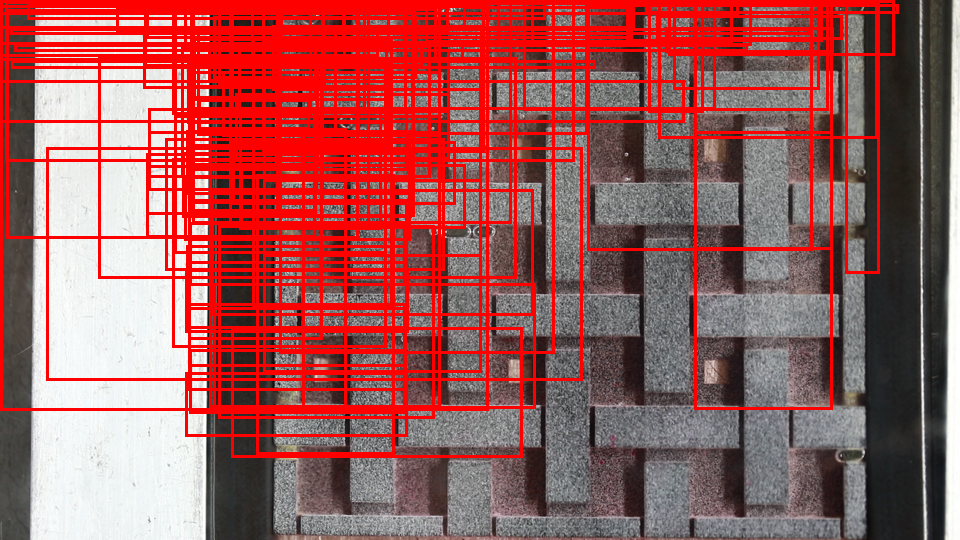

In [55]:
show_results(img,preds[0])

In [57]:
import pickle

In [58]:
with open('model.pkl','wb') as fp:
    pickle.dump(model.state_dict(),fp)